In [ ]:
import sys
sys.path.append('..')

from pytorch_lightning import Trainer
from data_modules.sw_detection_datamodule import SlowWaveDetectionData
from lightning_modules.resnet_sw_detect import ResnetSlowWave


model = ResnetSlowWave()
data_mod = SlowWaveDetectionData('../data/centered_data/', batch_size=16)

trainer = Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=5, val_check_interval=0.25)

In [ ]:
trainer.fit(model, data_mod)

# Save the model
trainer.save_checkpoint('centered_sw_model.ckpt')

# Evaluate the model

Analyse how the model performs on the validation and training datasets. The following cell loads a pre-trained model. Skip if training.

In [1]:
import sys
sys.path.append('..')

from pytorch_lightning import Trainer
from data_modules.sw_detection_datamodule import SlowWaveDetectionData
from lightning_modules.resnet_sw_detect import ResnetSlowWave

model = ResnetSlowWave.load_from_checkpoint('../saved_models/centered_sw_model.ckpt')
data_mod = SlowWaveDetectionData('../data/centered_data/', batch_size=1)

trainer = Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=5, val_check_interval=0.25)

/home/rsach/miniconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [2]:
import numpy as np
import pandas as pd

predictions = trainer.predict(model, data_mod)

num_batches = len(predictions)
numpy_data = np.zeros((0, 4), dtype=np.float32)

for batch_indx in range(num_batches):
    batch_size = len(predictions[0][1])
    
    y, probs = predictions[batch_indx]
    preds = probs.argmax(dim=1)
    
    y = y.cpu().numpy().reshape(-1, 1)
    probs = probs.cpu().numpy()
    preds = preds.cpu().numpy().reshape(-1, 1)
    
    numpy_data = np.vstack((numpy_data, np.hstack((y, probs, preds))))
    
df = pd.DataFrame(data=numpy_data, columns=['Label', 'No slow wave prob', 'Slow wave prob', 'Prediction'])
df.head()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

,Label,No slow wave prob,Slow wave prob,Prediction
0,0.0,0.938963,0.061037,0.0
1,0.0,0.973910,0.026090,0.0
2,0.0,0.975764,0.024236,0.0
3,0.0,0.981771,0.018229,0.0
4,0.0,0.990224,0.009776,0.0


Plot the confusion matrix to see how the model is doing.

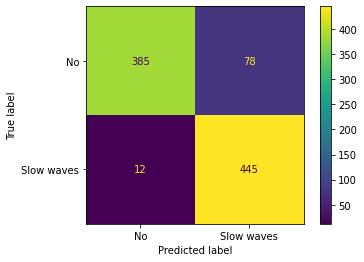

F1 score = 0.908163


In [3]:
import sklearn.metrics as skmetrics
import matplotlib.pyplot as plt

cm = skmetrics.confusion_matrix(df['Label'], df['Prediction'], labels=[0, 1])
cm_map = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Slow waves'])
cm_map.plot()
plt.show()

f1 = skmetrics.f1_score(df['Label'], df['Prediction'])
print('F1 score = {:f}'.format(f1))

We can detect centered slow waves. Let's see if we can calculate the slow wave activation time in the next model.